**1.**
Setup the enviornment and load the JSON file

In [ ]:
# setup the google drive mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) point this to my file ( Please add your own Google Takeout watch-history.json file)
path = '/content/drive/MyDrive/Colab Notebooks/watch-history.json'

# 2) load
with open(path, "r", encoding="utf-8") as f:
    raw = json.load(f)

print("Records:", len(raw))
print("Keys in first record:", raw[0].keys())
print("Sample title:", raw[0].get("title"))
print("Sample time:", raw[0].get("time"))

Records: 55900
Keys in first record: dict_keys(['header', 'title', 'titleUrl', 'time', 'products', 'details', 'activityControls'])
Sample title: Visited https://www.facebook.com/campaign/landing.php?campaign_id=23433294879&extra_1=|m|791591158009|||&placement=&creative=791591158009&keyword=&partner_id=googlesem&extra_2=campaignid%3D23433294879%26adgroupid%3D192012814755%26matchtype%3D%26network%3D%26source%3Dmobile%26search_or_content%3D%26device%3Dm%26devicemodel%3D%26adposition%3D%26target%3D%26targetid%3Daud-2459433571879%26loc_physical_ms%3D9030049%26loc_interest_ms%3D9030049%26feeditemid%3D%26param1%3D%26param2%3D&gad_source=2&gad_campaignid=23433294879
Sample time: 2026-02-11T04:19:08.670Z


**2.**
Convert to clean dataframe *(Data Wrangling)*

*2.1 - Flatten into dataframe*

In [ ]:
def get_channel(subtitles):
    """
    subtitles is usually a list like:
    [{'name': 'Channel Name', 'url': 'https://www.youtube.com/channel/...'}]
    """
    if isinstance(subtitles, list) and len(subtitles) > 0 and isinstance(subtitles[0], dict):
        return subtitles[0].get("name"), subtitles[0].get("url")
    return None, None

rows = []
for item in raw:
    channel_name, channel_url = get_channel(item.get("subtitles"))

    rows.append({
        "header": item.get("header"),
        "title": item.get("title"),
        "video_url": item.get("titleUrl"),
        "channel": channel_name,
        "channel_url": channel_url,
        "time_utc": item.get("time"),
        "products": ", ".join(item.get("products", [])) if item.get("products") else None,
        "activity_controls": item.get("activityControls"),
    })

df = pd.DataFrame(rows)
df.head()


,header,title,video_url,channel,channel_url,time_utc,products,activity_controls
0,YouTube,Visited https://www.facebook.com/campaign/land...,https://www.google.com/url?q=https://www.faceb...,None,None,2026-02-11T04:19:08.670Z,YouTube,"[Web & App Activity, YouTube watch history, Yo..."
1,YouTube,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,https://www.youtube.com/watch?v=Yemcj18O75s,NH Prime,https://www.youtube.com/channel/UCgQXzvzXRrZoh...,2026-02-11T04:16:32.951Z,YouTube,[YouTube watch history]
2,YouTube,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,https://www.youtube.com/watch?v=-k6dWCjQuJ4,4K Movies Hub,https://www.youtube.com/channel/UCXKLmS4LPy-bu...,2026-02-11T04:03:12.983Z,YouTube,[YouTube watch history]
3,YouTube,Viewed Ads On YouTube Homepage,None,None,None,2026-02-11T04:03:01.707Z,YouTube,"[Web & App Activity, YouTube watch history]"
4,YouTube,Watched Yunus Secret US Deal Out - 0 Tariffs f...,https://www.youtube.com/watch?v=uQNUdQuXJ4A,World Affairs by Unacademy,https://www.youtube.com/channel/UCCJsQKOKArvDk...,2026-02-11T03:53:20.174Z,YouTube,[YouTube watch history]


In [ ]:
# information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55900 entries, 0 to 55899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   header             55900 non-null  object
 1   title              55900 non-null  object
 2   video_url          55712 non-null  object
 3   channel            43328 non-null  object
 4   channel_url        43325 non-null  object
 5   time_utc           55900 non-null  object
 6   products           55900 non-null  object
 7   activity_controls  55900 non-null  object
dtypes: object(8)
memory usage: 3.4+ MB


In [ ]:
# the missing values in channel and channel_url are adds shown in between the youtube videos
# replace them with channel name as "ads" and  channel_url as "ads"
#df.loc[df["channel"].isna(), "channel"] = "ads"
#df.loc[df["channel_url"].isna(), "channel_url"] = "ads"

*2.2 - Parse time + add date features*

In [ ]:
# timezone correction
import pandas as pd
import numpy as np
df_watched = df.copy()
# 1) ensure time_utc exists and is parsed
df_watched["time_utc"] = pd.to_datetime(df_watched["time_utc"], errors="coerce", utc=True)
df_watched = df_watched.dropna(subset=["time_utc"]).copy()

def local_midnight_to_utc(date_str, tz):
    return pd.Timestamp(date_str + " 00:00:00", tz=tz).tz_convert("UTC")

# Boundaries in UTC based on local midnights
b1 = local_midnight_to_utc("2025-08-08", "Asia/Kolkata")       # India -> Arizona
b2 = local_midnight_to_utc("2025-12-14", "America/Phoenix")    # Arizona -> India
b3 = local_midnight_to_utc("2026-01-12", "Asia/Kolkata")       # India -> Arizona

t = df_watched["time_utc"]

m_india_1 = t < b1
m_az_1    = (t >= b1) & (t < b2)
m_india_2 = (t >= b2) & (t < b3)
m_az_2    = t >= b3

df_watched["timezone_used"] = np.select(
    [m_india_1, m_az_1, m_india_2, m_az_2],
    ["Asia/Kolkata", "America/Phoenix", "Asia/Kolkata", "America/Phoenix"],
    default="UTC"
)

# IMPORTANT: mixed timezones => object dtype
df_watched["time_local_correct"] = pd.Series([pd.NaT] * len(df_watched), dtype="object", index=df_watched.index)

mask_india = df_watched["timezone_used"] == "Asia/Kolkata"
df_watched.loc[mask_india, "time_local_correct"] = df_watched.loc[mask_india, "time_utc"].dt.tz_convert("Asia/Kolkata")

mask_az = df_watched["timezone_used"] == "America/Phoenix"
df_watched.loc[mask_az, "time_local_correct"] = df_watched.loc[mask_az, "time_utc"].dt.tz_convert("America/Phoenix")

print("Created time_local_correct. Missing:", df_watched["time_local_correct"].isna().sum())




Created time_local_correct. Missing: 0


In [ ]:
# Ensure there are no missing values
df_watched = df_watched[df_watched["time_local_correct"].notna()].copy()

# Extract features from tz-aware timestamps stored as objects
df_watched["date"] = df_watched["time_local_correct"].apply(lambda x: x.date())
df_watched["year"] = df_watched["time_local_correct"].apply(lambda x: x.year)
df_watched["month_name"] = df_watched["time_local_correct"].apply(lambda x: x.strftime("%B"))
df_watched["month"] = df_watched["time_local_correct"].apply(lambda x: x.month)
df_watched["weekday"] = df_watched["time_local_correct"].apply(lambda x: x.strftime("%A"))
df_watched["hour"] = df_watched["time_local_correct"].apply(lambda x: x.hour)



In [ ]:
df_watched.head()

,header,title,video_url,channel,channel_url,time_utc,products,activity_controls,timezone_used,time_local_correct,date,year,month_name,month,weekday,hour
0,YouTube,Visited https://www.facebook.com/campaign/land...,https://www.google.com/url?q=https://www.faceb...,None,None,2026-02-11 04:19:08.670000+00:00,YouTube,"[Web & App Activity, YouTube watch history, Yo...",America/Phoenix,2026-02-10 21:19:08.670000-07:00,2026-02-10,2026,February,2,Tuesday,21
1,YouTube,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,https://www.youtube.com/watch?v=Yemcj18O75s,NH Prime,https://www.youtube.com/channel/UCgQXzvzXRrZoh...,2026-02-11 04:16:32.951000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:16:32.951000-07:00,2026-02-10,2026,February,2,Tuesday,21
2,YouTube,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,https://www.youtube.com/watch?v=-k6dWCjQuJ4,4K Movies Hub,https://www.youtube.com/channel/UCXKLmS4LPy-bu...,2026-02-11 04:03:12.983000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:03:12.983000-07:00,2026-02-10,2026,February,2,Tuesday,21
3,YouTube,Viewed Ads On YouTube Homepage,None,None,None,2026-02-11 04:03:01.707000+00:00,YouTube,"[Web & App Activity, YouTube watch history]",America/Phoenix,2026-02-10 21:03:01.707000-07:00,2026-02-10,2026,February,2,Tuesday,21
4,YouTube,Watched Yunus Secret US Deal Out - 0 Tariffs f...,https://www.youtube.com/watch?v=uQNUdQuXJ4A,World Affairs by Unacademy,https://www.youtube.com/channel/UCCJsQKOKArvDk...,2026-02-11 03:53:20.174000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 20:53:20.174000-07:00,2026-02-10,2026,February,2,Tuesday,20


In [ ]:
def show_boundary(df, boundary_utc, days=1):
    window = (df["time_utc"] >= boundary_utc - pd.Timedelta(days=days)) & \
             (df["time_utc"] <= boundary_utc + pd.Timedelta(days=days))
    return df.loc[window, ["time_utc", "time_local_correct", "timezone_used", "hour", "weekday"]] \
             .sort_values("time_utc") \
             .head(20)

show_boundary(df_watched, b1)
show_boundary(df_watched, b2)
show_boundary(df_watched, b3)


,time_utc,time_local_correct,timezone_used,hour,weekday
2887,2026-01-11 03:46:13.730000+00:00,2026-01-11 09:16:13.730000+05:30,Asia/Kolkata,9,Sunday
2886,2026-01-11 03:46:17.940000+00:00,2026-01-11 09:16:17.940000+05:30,Asia/Kolkata,9,Sunday
2885,2026-01-11 03:47:44.613000+00:00,2026-01-11 09:17:44.613000+05:30,Asia/Kolkata,9,Sunday
2884,2026-01-11 03:47:44.613000+00:00,2026-01-11 09:17:44.613000+05:30,Asia/Kolkata,9,Sunday
2883,2026-01-11 03:47:59.677000+00:00,2026-01-11 09:17:59.677000+05:30,Asia/Kolkata,9,Sunday
2882,2026-01-11 03:50:16.039000+00:00,2026-01-11 09:20:16.039000+05:30,Asia/Kolkata,9,Sunday
2881,2026-01-11 03:58:39.919000+00:00,2026-01-11 09:28:39.919000+05:30,Asia/Kolkata,9,Sunday
2880,2026-01-11 03:58:56.823000+00:00,2026-01-11 09:28:56.823000+05:30,Asia/Kolkata,9,Sunday
2879,2026-01-11 03:59:27.544000+00:00,2026-01-11 09:29:27.544000+05:30,Asia/Kolkata,9,Sunday
2878,2026-01-11 04:00:00.082000+00:00,2026-01-11 09:30:00.082000+05:30,Asia/Kolkata,9,Sunday


In [ ]:
df_watched = df_watched[df_watched["time_local_correct"].notna()].copy()
df_watched["year_local"] = df_watched["time_local_correct"].apply(lambda x: x.year)

df_watched["year_local"].value_counts().sort_index()


,count
year_local,
2012,31
2013,39
2014,101
2015,112
2016,377
2017,466
2018,348
2019,1933
2020,5416


In [ ]:
df_watched.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55837 entries, 0 to 55899
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   header              55837 non-null  object             
 1   title               55837 non-null  object             
 2   video_url           55649 non-null  object             
 3   channel             43284 non-null  object             
 4   channel_url         43281 non-null  object             
 5   time_utc            55837 non-null  datetime64[ns, UTC]
 6   products            55837 non-null  object             
 7   activity_controls   55837 non-null  object             
 8   timezone_used       55837 non-null  object             
 9   time_local_correct  55837 non-null  object             
 10  date                55837 non-null  object             
 11  year                55837 non-null  int64              
 12  month_name          55837 non-null  o

*2.3 - Clean the “title” field (remove prefixes)*

In [ ]:
df_watched["title_raw"] = df_watched["title"]

prefixes = ("Watched ", "Visited ", "Searched for ", "Liked ", "Subscribed to ")

df_watched["title_clean"] = df_watched["title_raw"].fillna("")

for p in prefixes:
    df_watched["title_clean"] = df_watched["title_clean"].str.replace(
        f"^{p}", "", regex=True
    )

# Replace empty strings back to NaN
df_watched["title_clean"] = df_watched["title_clean"].replace("", np.nan)



In [ ]:
df_watched.head()

,header,title,video_url,channel,channel_url,time_utc,products,activity_controls,timezone_used,time_local_correct,date,year,month_name,month,weekday,hour,year_local,title_raw,title_clean
0,YouTube,Visited https://www.facebook.com/campaign/land...,https://www.google.com/url?q=https://www.faceb...,None,None,2026-02-11 04:19:08.670000+00:00,YouTube,"[Web & App Activity, YouTube watch history, Yo...",America/Phoenix,2026-02-10 21:19:08.670000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Visited https://www.facebook.com/campaign/land...,https://www.facebook.com/campaign/landing.php?...
1,YouTube,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,https://www.youtube.com/watch?v=Yemcj18O75s,NH Prime,https://www.youtube.com/channel/UCgQXzvzXRrZoh...,2026-02-11 04:16:32.951000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:16:32.951000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,अगर मैं होता तो माल यहाँ तक पहुँचता ही नहीं! स...
2,YouTube,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,https://www.youtube.com/watch?v=-k6dWCjQuJ4,4K Movies Hub,https://www.youtube.com/channel/UCXKLmS4LPy-bu...,2026-02-11 04:03:12.983000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:03:12.983000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,हम दोनों की तस्वीरें निकाल कर दुकान में लगा ले...
3,YouTube,Viewed Ads On YouTube Homepage,None,None,None,2026-02-11 04:03:01.707000+00:00,YouTube,"[Web & App Activity, YouTube watch history]",America/Phoenix,2026-02-10 21:03:01.707000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Viewed Ads On YouTube Homepage,Viewed Ads On YouTube Homepage
4,YouTube,Watched Yunus Secret US Deal Out - 0 Tariffs f...,https://www.youtube.com/watch?v=uQNUdQuXJ4A,World Affairs by Unacademy,https://www.youtube.com/channel/UCCJsQKOKArvDk...,2026-02-11 03:53:20.174000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 20:53:20.174000-07:00,2026-02-10,2026,February,2,Tuesday,20,2026,Watched Yunus Secret US Deal Out - 0 Tariffs f...,Yunus Secret US Deal Out - 0 Tariffs for B'des...


*2.4 - Keep only actual watch events (filter noise)*

In [ ]:
df_youtube = df_watched[
    (df_watched["video_url"].notna()) &
    (df_watched["header"] == "YouTube")
].copy()

print("All records:", len(df))
print("YouTube video records:", len(df_watched))


All records: 55900
YouTube video records: 55837


In [ ]:
df_youtube.head()


,header,title,video_url,channel,channel_url,time_utc,products,activity_controls,timezone_used,time_local_correct,date,year,month_name,month,weekday,hour,year_local,title_raw,title_clean
0,YouTube,Visited https://www.facebook.com/campaign/land...,https://www.google.com/url?q=https://www.faceb...,None,None,2026-02-11 04:19:08.670000+00:00,YouTube,"[Web & App Activity, YouTube watch history, Yo...",America/Phoenix,2026-02-10 21:19:08.670000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Visited https://www.facebook.com/campaign/land...,https://www.facebook.com/campaign/landing.php?...
1,YouTube,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,https://www.youtube.com/watch?v=Yemcj18O75s,NH Prime,https://www.youtube.com/channel/UCgQXzvzXRrZoh...,2026-02-11 04:16:32.951000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:16:32.951000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Watched अगर मैं होता तो माल यहाँ तक पहुँचता ही...,अगर मैं होता तो माल यहाँ तक पहुँचता ही नहीं! स...
2,YouTube,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,https://www.youtube.com/watch?v=-k6dWCjQuJ4,4K Movies Hub,https://www.youtube.com/channel/UCXKLmS4LPy-bu...,2026-02-11 04:03:12.983000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 21:03:12.983000-07:00,2026-02-10,2026,February,2,Tuesday,21,2026,Watched हम दोनों की तस्वीरें निकाल कर दुकान मे...,हम दोनों की तस्वीरें निकाल कर दुकान में लगा ले...
4,YouTube,Watched Yunus Secret US Deal Out - 0 Tariffs f...,https://www.youtube.com/watch?v=uQNUdQuXJ4A,World Affairs by Unacademy,https://www.youtube.com/channel/UCCJsQKOKArvDk...,2026-02-11 03:53:20.174000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 20:53:20.174000-07:00,2026-02-10,2026,February,2,Tuesday,20,2026,Watched Yunus Secret US Deal Out - 0 Tariffs f...,Yunus Secret US Deal Out - 0 Tariffs for B'des...
5,YouTube,Watched I Made an AI Influencer and Built Her ...,https://www.youtube.com/watch?v=FKzuk5gs1Xw,Vaibhav Sisinty,https://www.youtube.com/channel/UClXAalunTPaX1...,2026-02-11 03:45:59.730000+00:00,YouTube,[YouTube watch history],America/Phoenix,2026-02-10 20:45:59.730000-07:00,2026-02-10,2026,February,2,Tuesday,20,2026,Watched I Made an AI Influencer and Built Her ...,I Made an AI Influencer and Built Her a Full C...


*2.5 - Data quality check*

In [ ]:
# Missing values
df_youtube.isna().mean().sort_values(ascending = False)

# Check for duplicates
dup_count = df_youtube.duplicated(subset=["time_utc", "video_url"]).sum()
print("Duplicate (time_utc + video_url):", dup_count)


Duplicate (time_utc + video_url): 0


In [ ]:
# top channels watched
df_youtube["channel"].value_counts().head(10)

,count
channel,
Stock Market का Commando,2478
The Lallantop,2057
StudyIQ IAS,1411
Zee Business,1081
WION,868
World Affairs by Unacademy,632
Labour Law Advisor,532
T-Series,489
Think School,425


In [ ]:
# taking output of the cleaned data
output_path = "/content/drive/MyDrive/Colab Notebooks/ML_Learning/self_behaviour_analysis/history_all/df_watched.csv"

df_youtube.to_csv(output_path, index=False, encoding="utf-8")

print("File saved successfully to Drive!")

File saved successfully to Drive!


*2.6 - Split Youtube Vs Youtube Music*

In [ ]:
df_youtube = df_youtube[df_youtube["header"] == "YouTube"].copy()
df_music = df_watched[df_watched["header"] == "YouTube Music"].copy()

print("YouTube videos:", len(df_youtube))
print("YouTube Music:", len(df_music))


YouTube videos: 55277
YouTube Music: 372


In [ ]:
# Re-checking quality on YouTube-only data
df_youtube.isna().mean().sort_values(ascending = False)

,0
channel,0.223746
channel_url,0.223746
header,0.000000
video_url,0.000000
title,0.000000
time_utc,0.000000
products,0.000000
activity_controls,0.000000
timezone_used,0.000000
time_local_correct,0.000000


In [ ]:
df_youtube["year"].value_counts().sort_index()
df_youtube["channel"].value_counts().head(10)


,count
channel,
Stock Market का Commando,2478
The Lallantop,2057
StudyIQ IAS,1411
Zee Business,1081
WION,868
World Affairs by Unacademy,632
Labour Law Advisor,532
T-Series,489
Think School,425


**3. Sessionization**

In [ ]:
df_youtube = df_youtube[df_youtube["time_local_correct"].notna()].copy()

df_youtube = df_youtube.sort_values("time_local_correct").copy()

df_youtube["local_as_utc"] = df_youtube["time_local_correct"].apply(lambda x: x.tz_convert("UTC"))

df_youtube["time_diff_min_local"] = (
    df_youtube["local_as_utc"].diff().dt.total_seconds() / 60
)

df_youtube["new_session_local"] = (
    df_youtube["time_diff_min_local"].isna() |
    (df_youtube["time_diff_min_local"] > 30)
)

df_youtube["session_id_local"] = df_youtube["new_session_local"].cumsum()



In [ ]:
session_stats_local = (
    df_youtube
    .groupby("session_id_local")
    .agg(
        session_start_local=("time_local_correct", "min"),
        session_end_local=("time_local_correct", "max"),
        session_start_utc=("local_as_utc", "min"),
        session_end_utc=("local_as_utc", "max"),
        videos_in_session=("title_clean", "count"),
        unique_channels=("channel", "nunique"),
        start_hour=("hour", "first"),
        start_weekday=("weekday", "first"),
        start_date=("date", "first"),
        start_year=("year", "first"),
    )
    .reset_index()
)

# Creating session level metrics
session_stats_local["session_duration_min"] = (
    (session_stats_local["session_end_utc"] - session_stats_local["session_start_utc"])
    .dt.total_seconds() / 60
)

session_stats_local.head()


,session_id_local,session_start_local,session_end_local,session_start_utc,session_end_utc,videos_in_session,unique_channels,start_hour,start_weekday,start_date,start_year,session_duration_min
0,1,2012-07-15 08:41:48.171000+05:30,2012-07-15 08:41:48.171000+05:30,2012-07-15 03:11:48.171000+00:00,2012-07-15 03:11:48.171000+00:00,1,0,8,Sunday,2012-07-15,2012,0.000000
1,2,2012-07-15 09:21:43.608000+05:30,2012-07-15 09:25:15.934000+05:30,2012-07-15 03:51:43.608000+00:00,2012-07-15 03:55:15.934000+00:00,3,0,9,Sunday,2012-07-15,2012,3.538767
2,3,2012-07-21 08:39:27.430000+05:30,2012-07-21 09:07:22.089000+05:30,2012-07-21 03:09:27.430000+00:00,2012-07-21 03:37:22.089000+00:00,13,5,8,Saturday,2012-07-21,2012,27.910983
3,4,2012-07-22 15:11:04.759000+05:30,2012-07-22 15:11:04.759000+05:30,2012-07-22 09:41:04.759000+00:00,2012-07-22 09:41:04.759000+00:00,1,0,15,Sunday,2012-07-22,2012,0.000000
4,5,2012-07-23 21:07:48.981000+05:30,2012-07-23 21:11:59.833000+05:30,2012-07-23 15:37:48.981000+00:00,2012-07-23 15:41:59.833000+00:00,5,2,21,Monday,2012-07-23,2012,4.180867


In [ ]:
print("Sessions:", session_stats_local.shape[0])
print("Avg videos/session:", session_stats_local["videos_in_session"].mean())
print("Median session duration:", session_stats_local["session_duration_min"].median())


Sessions: 9275
Avg videos/session: 5.9597843665768195
Median session duration: 9.286316666666666


**4. Data Analysis**

In [ ]:
# Aggregation based on daily usages
daily_usage = (
    df_youtube
    .groupby("date")
    .agg(
        videos_watched=("title_clean", "count"),
        unique_channels=("channel", "nunique"),
        sessions=("session_id_local", "nunique")
    )
    .reset_index()
)


In [ ]:
# yearly trends
yearly_usage = (
    df_youtube
    .groupby("year")
    .agg(
        videos_watched=("title_clean", "count"),
        unique_channels=("channel", "nunique"),
        active_days=("date", "nunique")
    )
    .reset_index()
)


In [ ]:
channel_stats = (
    df_youtube
    .groupby("channel")
    .agg(
        videos_watched=("title_clean", "count"),
        first_watch=("time_local_correct", "min"),
        last_watch=("time_local_correct", "max"),
        active_days=("date", "nunique")
    )
    .reset_index()
    .sort_values("videos_watched", ascending=False)
)

channel_stats.head(10)

,channel,videos_watched,first_watch,last_watch,active_days
8269,Stock Market का Commando,2478,2020-02-04 08:47:53.963000+05:30,2026-02-08 08:32:33.476000-07:00,1121
8940,The Lallantop,2057,2019-01-14 17:30:49.247000+05:30,2026-01-28 14:02:30.121000-07:00,970
8309,StudyIQ IAS,1411,2019-07-20 12:25:03.958000+05:30,2026-02-10 20:34:48.318000-07:00,875
10177,Zee Business,1081,2021-04-12 08:45:58.241000+05:30,2026-02-10 20:24:14.855000-07:00,829
9845,WION,868,2020-03-21 21:40:07.346000+05:30,2025-10-25 12:24:27.861000-07:00,491
9983,World Affairs by Unacademy,632,2020-10-31 18:01:07.152000+05:30,2026-02-10 20:53:20.174000-07:00,450
4757,Labour Law Advisor,532,2019-08-09 21:14:33.508000+05:30,2026-02-10 09:49:43.349000-07:00,374
8456,T-Series,489,2013-11-06 12:15:26.520000+05:30,2026-01-31 14:37:39.372000-07:00,311
9159,Think School,425,2021-04-17 10:25:01.274000+05:30,2026-02-10 10:00:38.678000-07:00,385
5293,Max Amini,327,2024-06-05 08:20:42.609000+05:30,2026-02-10 10:00:07.410000-07:00,209


In [ ]:
# create behavioural signals
df_youtube["is_weekend"] = df_youtube["weekday"].isin(["Saturday", "Sunday"])
df_youtube["is_late_night"] = df_youtube["hour"].between(22, 3)
df_youtube["is_work_hours"] = df_youtube["hour"].between(9, 17)


In [ ]:
# save all wrangled dataset
df_youtube.to_parquet("youtube_videos_clean.parquet", index=False)
session_stats_local.to_parquet("youtube_sessions.parquet")
daily_usage.to_parquet("youtube_daily_usage.parquet", index=False)
yearly_usage.to_parquet("youtube_yearly_usage.parquet", index=False)
channel_stats.to_parquet("youtube_channel_stats.parquet", index=False)


** 5. Exploratory Data Analysis**\
*5.1 - Volume and growth over time*

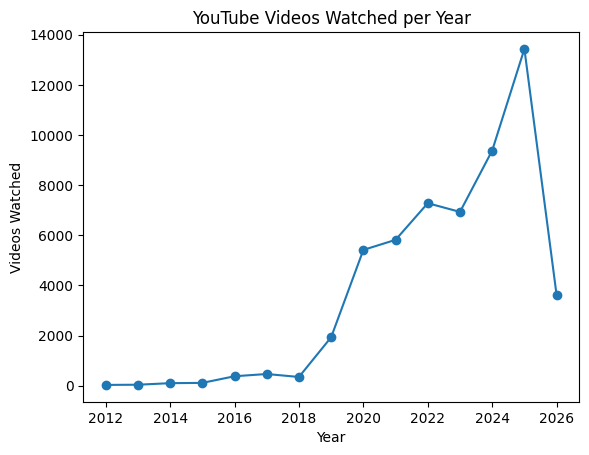

In [ ]:
# 1) Number of videos watched per year
import matplotlib.pyplot as plt

year_counts = (
    df_youtube
    .groupby("year")
    .size()
    .reset_index(name="videos")
)

plt.figure()
plt.plot(year_counts["year"], year_counts["videos"], marker="o")
plt.xlabel("Year")
plt.ylabel("Videos Watched")
plt.title("YouTube Videos Watched per Year")
plt.show()


In [ ]:
print("Years present in df_youtube:")
display(df_youtube["year"].value_counts().sort_index())

Years present in df_youtube:


,count
year,
2012,31
2013,39
2014,101
2015,112
2016,377
2017,466
2018,348
2019,1933
2020,5416


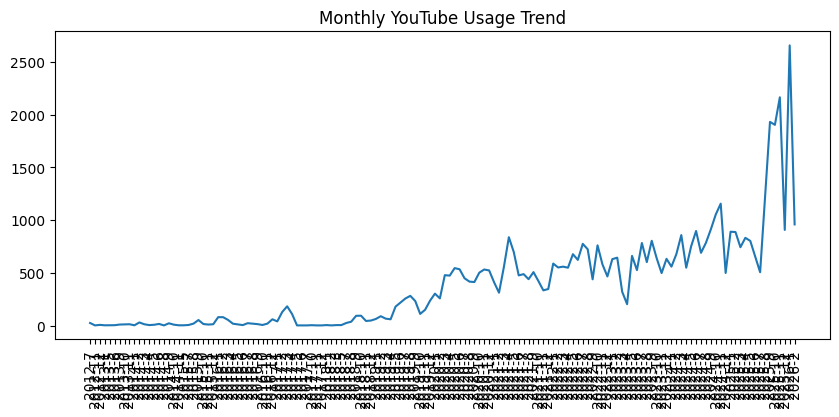

In [ ]:
# 2) Monthly seasoality
monthly = (
    df_youtube
    .groupby(["year", "month"])
    .size()
    .reset_index(name="videos")
)

monthly["year_month"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)

plt.figure(figsize=(10,4))
plt.plot(monthly["year_month"], monthly["videos"])
plt.xticks(rotation=90)
plt.title("Monthly YouTube Usage Trend")
plt.show()


*5.2 - Time of day & weekday pattern*

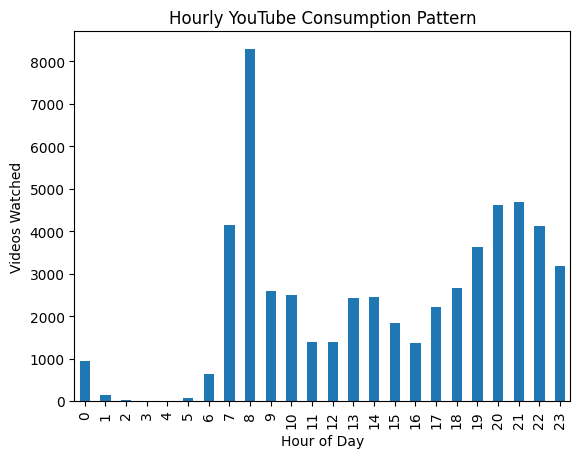

In [ ]:
#3) Time of day which i watch it most
hourly = df_youtube.groupby("hour").size()

plt.figure()
hourly.plot(kind="bar")
plt.xlabel("Hour of Day")
plt.ylabel("Videos Watched")
plt.title("Hourly YouTube Consumption Pattern")
plt.show()


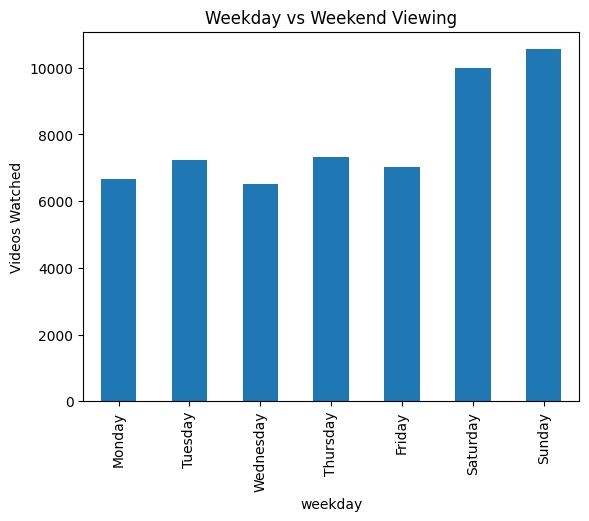

In [ ]:
# 4) Weekday vs Weekend consumption
weekday_order = [
    "Monday","Tuesday","Wednesday",
    "Thursday","Friday","Saturday","Sunday"
]

weekday_counts = (
    df_youtube["weekday"]
    .value_counts()
    .reindex(weekday_order)
)

plt.figure()
weekday_counts.plot(kind="bar")
plt.title("Weekday vs Weekend Viewing")
plt.ylabel("Videos Watched")
plt.show()


*5.3 - Channel preference ( concentration & Diversity)*

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


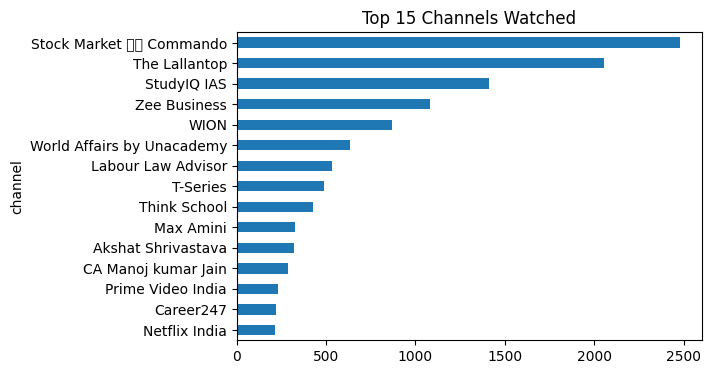

In [ ]:
# 5) Top 15 watched channel
top_channels = (
    df_youtube["channel"]
    .value_counts()
    .head(15)
)

plt.figure(figsize=(6,4))
top_channels.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Channels Watched")
plt.show()


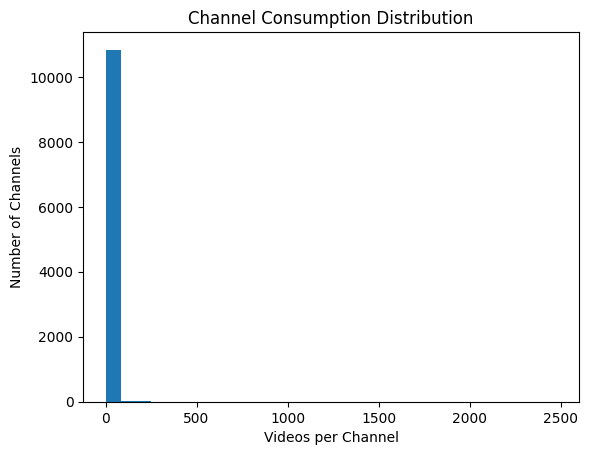

In [ ]:
# 6) Long-tail behavior (explorer Vs core follower)
channel_counts = df_youtube["channel"].value_counts()

plt.figure()
plt.hist(channel_counts, bins=30)
plt.xlabel("Videos per Channel")
plt.ylabel("Number of Channels")
plt.title("Channel Consumption Distribution")
plt.show()


*5.4 - Session abd Binge behaviour*

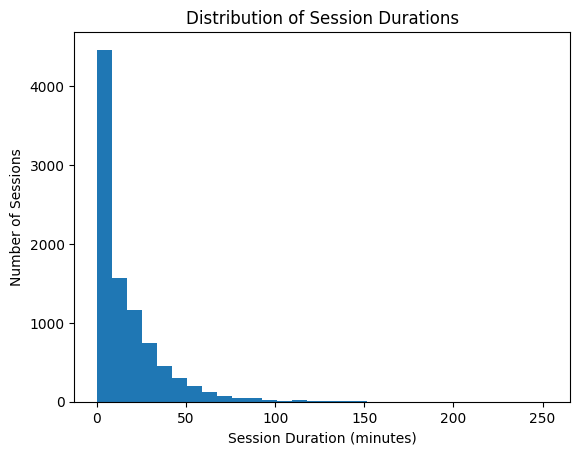

In [ ]:
#7) How long are my seesions
plt.figure()
plt.hist(session_stats_local["session_duration_min"], bins=30)
plt.xlabel("Session Duration (minutes)")
plt.ylabel("Number of Sessions")
plt.title("Distribution of Session Durations")
plt.show()


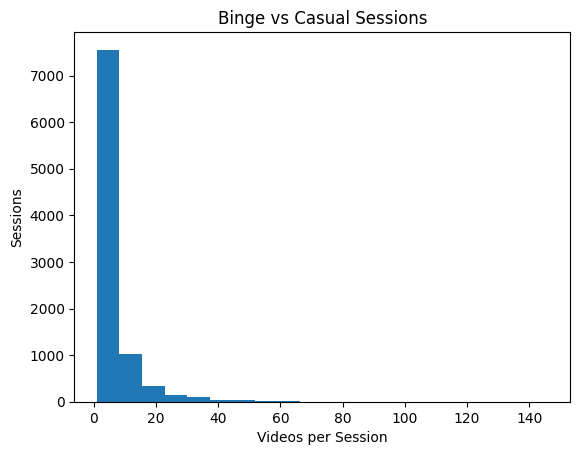

In [ ]:
# 8) Videos per session
plt.figure()
plt.hist(session_stats_local["videos_in_session"], bins=20)
plt.xlabel("Videos per Session")
plt.ylabel("Sessions")
plt.title("Binge vs Casual Sessions")
plt.show()


**6. Extracting / Tabulating Data for creating Dashboard**

In [ ]:
# 6.1 youtube_events
output_path = "/content/drive/MyDrive/Colab Notebooks/ML_Learning/self_behaviour_analysis/history_all/youtube_events.csv"

youtube_events = df_youtube[[
    "time_utc",
    "date",
    "year",
    "month",
    "month_name",
    "weekday",
    "hour",
    "channel",
    "title_clean",
    "session_id_local"
]].copy()

youtube_events.to_csv(output_path, index=False, encoding="utf-8")


In [ ]:
# 6.2 youtube_Sessions
output_path = "/content/drive/MyDrive/Colab Notebooks/ML_Learning/self_behaviour_analysis/history_all/youtube_sessions.csv"

session_export = session_stats_local[[
    "session_id_local",
    "session_start_local",
    "session_duration_min",
    "videos_in_session",
    "unique_channels",
    "start_year",
    "start_date",
    "start_hour",
    "start_weekday"
]].copy()

session_export.to_csv(output_path, index=False, encoding="utf-8")
